# HEOM 1e: Spin-Bath model (pure dephasing)

## Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do the Matsubara and Pade analytical decompositions, as well as how to fit the latter with a finite set of approximate exponentials.  This differs from example 1a in that we assume that the system and coupling parts of the Hamiltonian commute, hence giving an analytically solvable ''pure dephasing'' model. This is a useful example to look at when introducing other approximations  (e.g., fitting of correlation functions) to check for validity/convergence against the analytical results.  (Note that, generally, for the fitting examples, the pure dephasing model is the 'worst possible case'.)

### Drude-Lorentz spectral density

The Drude-Lorentz spectral density is:

$$J(\omega)=\omega \frac{2\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.
We use the convention,
\begin{equation*}
C(t) = \int_0^{\infty} d\omega \frac{J_D(\omega)}{\pi}[\coth(\beta\omega) \cos(\omega \tau) - i \sin(\omega \tau)]
\end{equation*}

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

The Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta \hbar}  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) / \hbar               & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \hbar^2 \}    & k \geq 1\\
           \end{cases}
\end{equation*}

Note that in the above, and the following, we set $\hbar = k_\mathrm{B} = 1$.

## Setup

In [1]:
import contextlib
import time

import numpy as np
import scipy
from matplotlib import pyplot as plt

from qutip import about, basis, expect, liouvillian, sigmax, sigmaz
from qutip.core.environment import DrudeLorentzEnvironment, system_terminator
from qutip.solver.heom import HEOMSolver

%matplotlib inline

## Helper functions

Let's define some helper functions for calculating correlation function expansions, plotting results and timing how long operations take:

In [2]:
def cot(x):
    """ Vectorized cotangent of x. """
    return 1.0 / np.tan(x)


def coth(x):
    """ Vectorized hyperbolic cotangent of x. """
    return 1.0 / np.tanh(x)

In [3]:
def plot_result_expectations(plots, axes=None):
    """ Plot the expectation values of operators as functions of time.

        Each plot in plots consists of (solver_result, measurement_operation,
        color, label).
    """
    if axes is None:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))
        fig_created = True
    else:
        fig = None
        fig_created = False

    # add kw arguments to each plot if missing
    plots = [p if len(p) == 5 else p + ({},) for p in plots]
    for result, m_op, color, label, kw in plots:
        if m_op is None:
            t, exp = result
        else:
            t = result.times
            exp = np.real(expect(result.states, m_op))
        kw.setdefault("linewidth", 2)
        axes.plot(t, exp, color, label=label, **kw)

    if fig_created:
        axes.legend(loc=0, fontsize=12)
        axes.set_xlabel("t", fontsize=28)

    return fig

In [4]:
@contextlib.contextmanager
def timer(label):
    """ Simple utility for timing functions:

        with timer("name"):
            ... code to time ...
    """
    start = time.time()
    yield
    end = time.time()
    print(f"{label}: {end - start}")

In [5]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-14,
    "atol": 1e-14,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

And let us set up the system Hamiltonian, bath and system measurement operators:

Here we set $H_{sys}=0$, which means the interaction Hamiltonian and the system Hamiltonian commute, and we can compare the numerical results to a known analytical one.  We could in principle keep $\epsilon \neq 0$, but it just introduces fast system oscillations, so it is more convenient to set it to zero.

In [6]:
# Defining the system Hamiltonian
eps = 0.0  # Energy of the 2-level system.
Del = 0.0  # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del * sigmax()

In [7]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz()  # coupling operator

# Bath properties:
gamma = 0.5  # cut off frequency
lam = 0.1  # coupling strength
T = 0.5
beta = 1.0 / T

# HEOM parameters:
# cut off parameter for the bath:
NC = 6
# number of exponents to retain in the Matsubara expansion
# of the correlation function:
Nk = 3

# Times to solve for
tlist = np.linspace(0, 50, 1000)

In [8]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresponding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresponding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

To get a non-trivial result we prepare the initial state in a superposition, and see how the bath destroys the coherence.

In [9]:
# Initial state of the system.
psi = (basis(2, 0) + basis(2, 1)).unit()
rho0 = psi * psi.dag()

We then define our environment, from which all the different simulations will 
be obtained

In [10]:
env = DrudeLorentzEnvironment(lam=lam, gamma=gamma, T=T, Nk=Nk)

## Simulation 1: Matsubara decomposition, not using Ishizaki-Tanimura terminator

In [11]:
with timer("RHS construction time"):
    env_mats = env.approximate(method="matsubara", Nk=Nk)
    HEOMMats = HEOMSolver(Hsys, (env_mats, Q), NC, options=options)

with timer("ODE solver time"):
    resultMats = HEOMMats.run(rho0, tlist)

RHS construction time: 0.021390676498413086
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 Total run time:   0.81s
ODE solver time: 0.8131468296051025


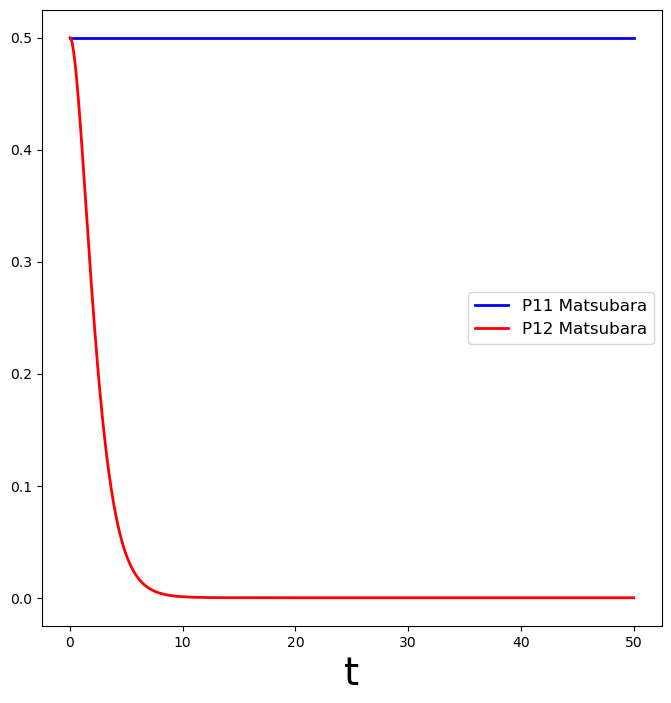

In [12]:
# Plot the results so far
plot_result_expectations([
    (resultMats, P11p, 'b', "P11 Matsubara"),
    (resultMats, P12p, 'r', "P12 Matsubara"),
]);

## Simulation 2: Matsubara decomposition (including terminator)

In [13]:
with timer("RHS construction time"):
    env_mats, delta = env.approximate(
        method="matsubara", Nk=Nk, compute_delta=True
    )
    Ltot = liouvillian(Hsys) + system_terminator(Q, delta)
    HEOMMatsT = HEOMSolver(Ltot, (env_mats, Q), NC, options=options)

with timer("ODE solver time"):
    resultMatsT = HEOMMatsT.run(rho0, tlist)

RHS construction time: 0.02381134033203125


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.79s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.80s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.81s / Remaining 00:00:00:00

 Total run time:   0.81s
ODE solver time: 0.812126874923706


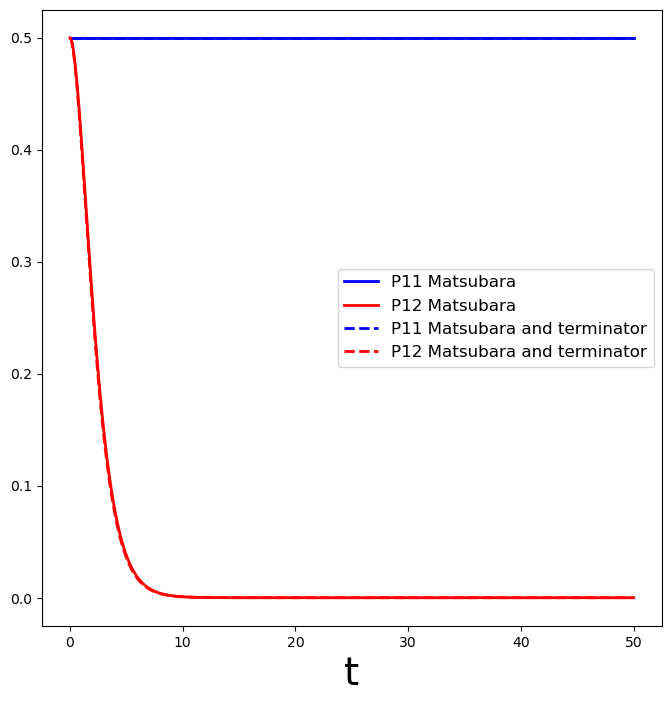

In [14]:
# Plot the results
plot_result_expectations([
    (resultMats, P11p, 'b', "P11 Matsubara"),
    (resultMats, P12p, 'r', "P12 Matsubara"),
    (resultMatsT, P11p, 'b--', "P11 Matsubara and terminator"),
    (resultMatsT, P12p, 'r--', "P12 Matsubara and terminator"),
]);

## Simulation 3: Pade decomposition

As in example 1a, we can compare to Pade and Fitting approaches.

In [15]:
with timer("RHS construction time"):
    env_pade = env.approximate(method="pade", Nk=Nk)
    HEOMPade = HEOMSolver(Hsys, (env_pade, Q), NC, options=options)

with timer("ODE solver time"):
    resultPade = HEOMPade.run(rho0, tlist)

RHS construction time: 0.023072481155395508


 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         3%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.03s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.04s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         5%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.05s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [*         6%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.06s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        7%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.07s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        8%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.08s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**        9%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.09s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [**       10%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.10s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      11%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.11s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      12%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.12s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      13%           ] Elapsed 0.13s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      14%           ] Elapsed 0.14s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.15s / Remaining 00:00:00:00

 [***      15%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.16s / Remaining 00:00:00:00

 [****     16%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.17s / Remaining 00:00:00:00

 [****     17%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.18s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     18%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.19s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [****     19%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.20s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    20%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.21s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    21%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.22s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    22%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.23s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [*****    23%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.24s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   24%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.25s / Remaining 00:00:00:00

 [******   25%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   26%           ] Elapsed 0.26s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.27s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.28s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.29s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.30s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.31s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.32s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.33s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.34s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.35s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.36s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.96s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.97s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.98s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.99s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.99s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.99s / Remaining 00:00:00:00

 [********100%***********] Elapsed 0.99s / Remaining 00:00:00:00

 Total run time:   0.99s
ODE solver time: 0.9888460636138916


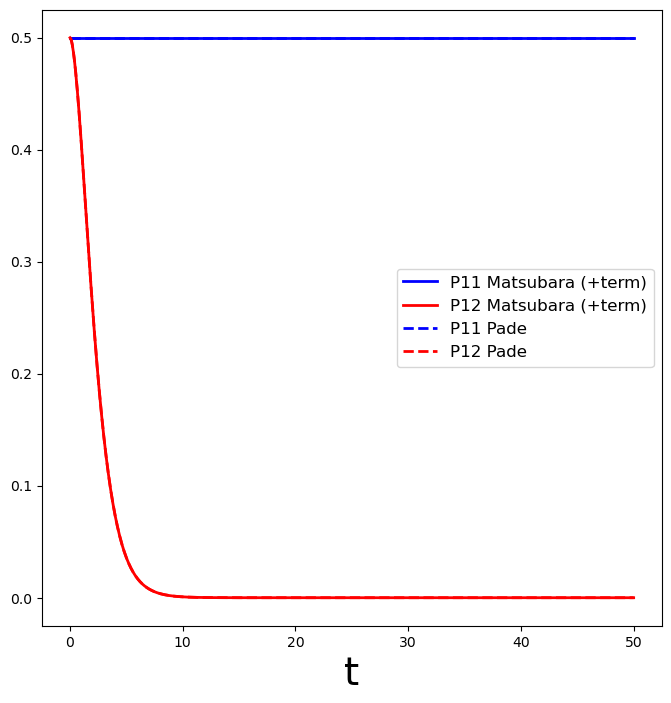

In [16]:
# Plot the results
plot_result_expectations([
    (resultMatsT, P11p, 'b', "P11 Matsubara (+term)"),
    (resultMatsT, P12p, 'r', "P12 Matsubara (+term)"),
    (resultPade, P11p, 'b--', "P11 Pade"),
    (resultPade, P12p, 'r--', "P12 Pade"),
]);

## Simulation 4: Fitting approach

In [17]:
tfit = np.linspace(0, 10, 1000)
with timer("RHS construction time"):
    env_fit, _ = env.approximate(
        method="cf", tlist=tfit, Ni_max=1, Nr_max=3, target_rmse=None
    )
    HEOMFit = HEOMSolver(Hsys, (env_fit, Q), NC, options=options)

with timer("ODE solver time"):
    resultFit = HEOMFit.run(rho0, tlist)

RHS construction time: 0.3485550880432129
 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          0%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.01s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          1%           ] Elapsed 0.02s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.02s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [          2%           ] Elapsed 0.03s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.04s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         3%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.05s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         4%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.06s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.07s / Remaining 00:00:00:01

 [*         5%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.08s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [*         6%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.09s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        7%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.10s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.11s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        8%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.12s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**        9%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.13s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [**       10%           ] Elapsed 0.14s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.15s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      11%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.16s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      12%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.17s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.18s / Remaining 00:00:00:01

 [***      13%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.19s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      14%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.20s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [***      15%           ] Elapsed 0.21s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.22s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     16%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.23s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     17%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.24s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.25s / Remaining 00:00:00:01

 [****     18%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.26s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [****     19%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.27s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [*****    20%           ] Elapsed 0.28s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.29s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    21%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.30s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    22%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.31s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.32s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [*****    23%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.33s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   24%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.34s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   25%           ] Elapsed 0.35s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.36s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   26%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.37s / Remaining 00:00:00:00

 [******   27%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.37s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   27%           ] Elapsed 0.38s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.38s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:00

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.39s / Remaining 00:00:00:01

 [******   28%           ] Elapsed 0.40s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.40s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*******  29%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*******  29%           ] Elapsed 0.41s / Remaining 00:00:00:01

 [*******  30%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.41s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  30%           ] Elapsed 0.42s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.43s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.44s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [*******  32%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.45s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.46s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 33%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.47s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 34%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.48s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 35%           ] Elapsed 0.49s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.50s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [******** 36%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.51s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********37%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.52s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.53s / Remaining 00:00:00:00

 [*********38%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.54s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********39%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.55s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********40%           ] Elapsed 0.56s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.57s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********41%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.58s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********42%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.59s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.60s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********43%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.61s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********44%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.62s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.63s / Remaining 00:00:00:00

 [*********45%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.64s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********46%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.65s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.66s / Remaining 00:00:00:00

 [*********47%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.67s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********48%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.68s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.69s / Remaining 00:00:00:00

 [*********49%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.70s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********50%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.71s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.72s / Remaining 00:00:00:00

 [*********51%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.73s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********52%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.74s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********53%           ] Elapsed 0.75s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.76s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********54%           ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.77s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********55%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.78s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.79s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********56%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.80s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********57%*          ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.81s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.82s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********58%*          ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.83s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********59%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.84s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.85s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********60%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.86s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********61%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.87s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********62%**         ] Elapsed 0.88s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.89s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********63%**         ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.90s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********64%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.91s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.92s / Remaining 00:00:00:00

 [*********65%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.93s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********66%***        ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.94s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********67%***        ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.95s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.96s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********68%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.97s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********69%****       ] Elapsed 0.98s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 0.99s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********70%****       ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.00s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********71%****       ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.01s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.02s / Remaining 00:00:00:00

 [*********72%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.03s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.04s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.05s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.06s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.07s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.08s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.09s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.10s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.11s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.12s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.13s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.14s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.16s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.17s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 1.18s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.19s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.20s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.21s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.22s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.23s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.24s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.25s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 1.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.28s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.29s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.30s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 1.31s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.32s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.33s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.34s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.35s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 1.36s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.37s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.38s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 1.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.38s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.39s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 1.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.39s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.40s / Remaining 00:00:00:00

 [********100%***********] Elapsed 1.40s / Remaining 00:00:00:00

 Total run time:   1.40s
ODE solver time: 1.3994812965393066


## Analytic calculations

In [18]:
def pure_dephasing_evolution_analytical(tlist, wq, ck, vk):
    """
    Computes the propagating function appearing in the pure dephasing model.

    Parameters
    ----------
    t: float
        A float specifying the time at which to calculate the integral.

    wq: float
        The qubit frequency in the Hamiltonian.

    ck: ndarray
        The list of coefficients in the correlation function.

    vk: ndarray
        The list of frequencies in the correlation function.

    Returns
    -------
    integral: float
        The value of the integral function at time t.
    """
    evolution = np.array(
        [np.exp(-1j * wq * t - correlation_integral(t, ck, vk)) for t in tlist]
    )
    return evolution


def correlation_integral(t, ck, vk):
    r"""
    Computes the integral sum function appearing in the pure dephasing model.

    If the correlation function is a sum of exponentials then this sum
    is given by:

    .. math:

        \int_0^{t}d\tau D(\tau) = \sum_k\frac{c_k}{\mu_k^2}e^{\mu_k t}
        + \frac{\bar c_k}{\bar \mu_k^2}e^{\bar \mu_k t}
        - \frac{\bar \mu_k c_k + \mu_k \bar c_k}{\mu_k \bar \mu_k} t
        + \frac{\bar \mu_k^2 c_k + \mu_k^2 \bar c_k}{\mu_k^2 \bar \mu_k^2}

    Parameters
    ----------
    t: float
        A float specifying the time at which to calculate the integral.

    ck: ndarray
        The list of coefficients in the correlation function.

    vk: ndarray
        The list of frequencies in the correlation function.

    Returns
    -------
    integral: float
        The value of the integral function at time t.
    """
    t1 = np.sum((ck / vk**2) * (np.exp(vk * t) - 1))
    t2 = np.sum((ck.conj() / vk.conj()**2) * (np.exp(vk.conj() * t) - 1))
    t3 = np.sum((ck / vk + ck.conj() / vk.conj()) * t)
    return 2 * (t1 + t2 - t3)

For the pure dephasing analytics, we just sum up as many matsubara terms as we can:

In [19]:
lmaxmats2 = 15000

vk = [complex(-gamma)]
vk.extend([complex(-2.0 * np.pi * k * T) for k in range(1, lmaxmats2)])

ck = [complex(lam * gamma * (-1.0j + cot(gamma * beta / 2.0)))]
ck.extend(
    [complex(4 * lam * gamma * T * (-v) / (v**2 - gamma**2)) for v in vk[1:]]
)

P12_ana = 0.5 * pure_dephasing_evolution_analytical(
    tlist, 0, np.asarray(ck), np.asarray(vk)
)

Alternatively, we can just do the integral of the propagator directly, without using the correlation functions at all

In [20]:
def JDL(omega, lamc, omega_c):
    return 2.0 * lamc * omega * omega_c / (omega_c**2 + omega**2)


def integrand(omega, lamc, omega_c, Temp, t):
    return (
        (-4.0 * JDL(omega, lamc, omega_c) / omega**2) *
        (1.0 - np.cos(omega*t)) * (coth(omega/(2*Temp)))
        / np.pi
    )


P12_ana2 = [
    0.5 * np.exp(
        scipy.integrate.quad(integrand, 0, np.inf, args=(lam, gamma, T, t))[0]
    )
    for t in tlist
]

/tmp/ipykernel_10338/2313629077.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  scipy.integrate.quad(integrand, 0, np.inf, args=(lam, gamma, T, t))[0]


## Compare results

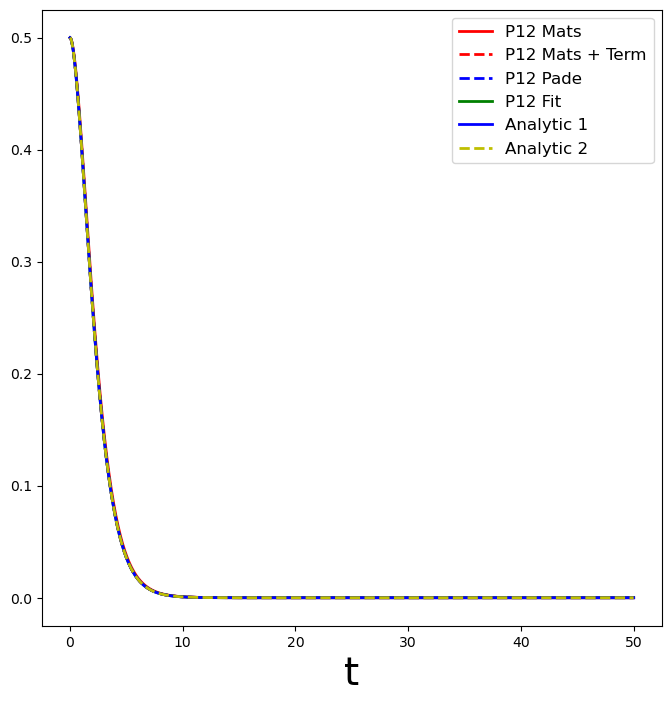

In [21]:
plot_result_expectations([
    (resultMats, P12p, 'r', "P12 Mats"),
    (resultMatsT, P12p, 'r--', "P12 Mats + Term"),
    (resultPade, P12p, 'b--', "P12 Pade"),
    (resultFit, P12p, 'g', "P12 Fit"),
    ((tlist, np.real(P12_ana)), None, 'b', "Analytic 1"),
    ((tlist, np.real(P12_ana2)), None, 'y--', "Analytic 2"),
]);

We can't see much difference in the plot above, so let's do a log plot instead:

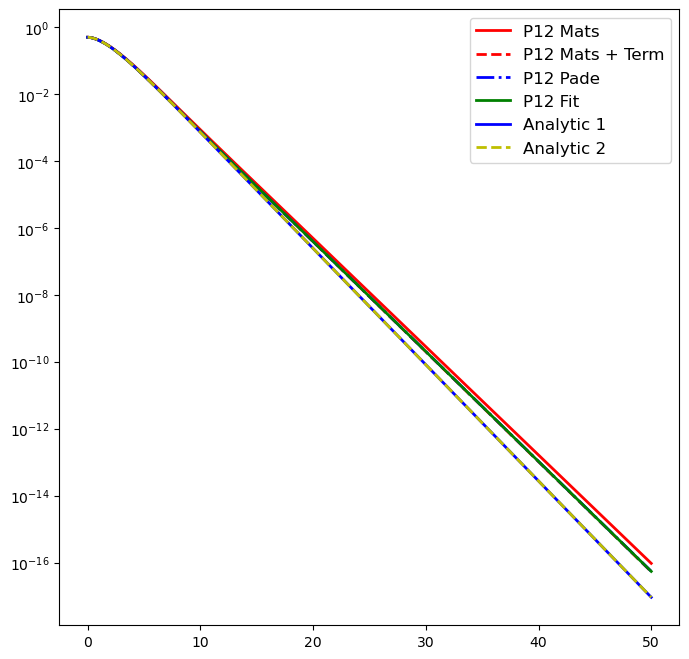

In [22]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 8))

plot_result_expectations([
    (resultMats, P12p, 'r', "P12 Mats"),
    (resultMatsT, P12p, 'r--', "P12 Mats + Term"),
    (resultPade, P12p, 'b-.', "P12 Pade"),
    (resultFit, P12p, 'g', "P12 Fit"),
    ((tlist, np.real(P12_ana)), None, 'b', "Analytic 1"),
    ((tlist, np.real(P12_ana2)), None, 'y--', "Analytic 2"),
], axes)

axes.set_yscale('log')
axes.legend(loc=0, fontsize=12);

## About

In [23]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [24]:
assert np.allclose(
    expect(P12p, resultMats.states[:15]), np.real(P12_ana)[:15],
    rtol=1e-2,
)
assert np.allclose(
    expect(P12p, resultMatsT.states[:100]), np.real(P12_ana)[:100],
    rtol=1e-3,
)
assert np.allclose(
    expect(P12p, resultPade.states[:100]), np.real(P12_ana)[:100],
    rtol=1e-3,
)
assert np.allclose(
    expect(P12p, resultFit.states[:50]), np.real(P12_ana)[:50],
    rtol=1e-3,
)
assert np.allclose(P12_ana, P12_ana2, rtol=1e-3)